# In the Time of COVID: A text and sentiment analysis of individual stories in the time of the SARS-CoV-2 pandemic
#### by Diedre Brown, Pratt Institute, Spring 2021

Inspired by the Date Paintings of Japanese conceptual artist, On Kawara, and the (Süd-) Koreanischer Kalender / (South) Korean Calendar (1991) created by German conceptual artist, Hanne Darboven, this project used an online survey to collect pertinent dates and stories of thirteen (13) individuals during the COVID-19 pandemic (1 January 2020). The data was cleaned and analyzed via text and sentiment anlysis. As part of a prototype to visualize both quantitative and qualitative data, this analysis will contribute to an ongoing "data display" project that will allow users to not only trace the reported COVID cases and death tolls by date, but some personal sentiments and/or reflections of people as well.

### Import Libraries

In [2]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import re

In [3]:
%matplotlib inline
#makes inline plots to have better quality
%config InlineBackend.figure_format = 'png'
#set the default style to be colorblind friendly
plt.style.use("seaborn-colorblind")

In [4]:
pd.set_option('mode.chained_assignment', None)

In [5]:
# Scikit Learn Libraries
import sklearn
sklearn.__version__>="0.20"

True

In [6]:
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression,ElasticNetCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

In [7]:
# Natural Language Toolkit Library - NLTK
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [8]:
# spaCy another Natural Language Processing library built for Python/Cython
# spaCy has the fastest syntactic parser, which helps increase it's accuracy over nltk
import string
import spacy


In [9]:
spacy.load('en_core_web_lg')

In [10]:
from spacy.lang.en import English
nlp = English() # use directly

In [11]:
import plotly.express as px #plotly express
import plotly.graph_objects as go #plotly graph objects
# dash stuff
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

In [12]:
# import the logging library to expose the interface that the application code directly uses.
import logging
# logging levels
# CRITICAL (50) - A serious error, indicating that the program itself may be unable to continue running.
# ERROR (40) - Due to a more serious problem, the software has not been able to perform some function.
# WARNING (30) - An indication that something unexpected happened, or indicative of some problem in the near future (e.g. 'disk space low'). The software is still working as expected.
# INFO (20) - Confirmation that things are working as expected.
# DEBUG (10) - Detailed information, typically of interest only when diagnosing problems.
# NOTSET (0) -

In [13]:
logFormatter = '%(asctime)s - %(levelname)s - %(message)s' # logging formatted as time, level name, and message
logging.basicConfig(format=logFormatter, level=logging.INFO) # sets the default logging level, and the log formatting
logger = logging.getLogger(__name__) # 
# run first log
logger.info("initial log")



2021-04-19 13:42:24,445 - INFO - initial log


### Load Data

In [14]:
df_survey_raw = pd.read_csv("/Users/diedrebrown/Desktop/GitHubRepos/inthetimeofcovid/data/ITCResponses-clean.csv")

In [15]:
df_survey_raw.head()

,P,Age,Gender,CDate,CCity,CState,Ccountry-iso_alpha,Mem,3Wrds,ColorB,ColorHex,ColorRes
0,A,25-40,Female,3/11/20,Surrey,British Columbia,CAN,I recall having a team meeting at work with lo...,"Fun, overwhelming, tiring",I have no color deficiency.,NONE,NONE
1,B,25-40,Female,1/24/20,Brooklyn,New York,USA,A lot of things came to my mind. It was hard t...,"Chinese, friendly, funny",I have no color deficiency.,#CC0000,Red is the official color of Chinese New Year:)
2,C,41-55,Female,3/13/20,Brooklyn,New York,USA,It was the day that I learned that public scho...,"disbelief, confusion, concern",I have no color deficiency.,#660000,"Red reminds me of school, and concern"
3,D,25-40,Female,3/30/20,Radford,Virgina,USA,My Grandmother passed away and we couldn’t gri...,"Angry, Sunken, bitter",I have no color deficiency.,#330066,It feels like a somber color
4,E,25-40,Male,3/8/20,Newark,New Jersey,USA,I hope this doesn’t feel like too ‘silly’ of a...,"Exhilarating, overindulgent, inspiring",I have no color deficiency.,#CC0000,"The concert design largely used this color, so..."


In [16]:
df_survey_raw.shape

(14, 12)

In [17]:
# gender column actually describes sex. change gender column name to sex
df_survey_raw = df_survey_raw.rename({"Gender":"Sex"}, axis=1)
df_survey_raw.head(1)

,P,Age,Sex,CDate,CCity,CState,Ccountry-iso_alpha,Mem,3Wrds,ColorB,ColorHex,ColorRes
0,A,25-40,Female,3/11/20,Surrey,British Columbia,CAN,I recall having a team meeting at work with lo...,"Fun, overwhelming, tiring",I have no color deficiency.,NONE,NONE


In [18]:
# convert CDate column to datetime format and extract a year, month-day
df_survey_raw['CDate'] = pd.to_datetime(df_survey_raw['CDate'])
df_survey_raw['CDyear'] = df_survey_raw['CDate'].dt.year
df_survey_raw['CDmm-dd'] = df_survey_raw['CDate'].dt.strftime('%m-%d')
df_survey_raw.head(1)

,P,Age,Sex,CDate,CCity,CState,Ccountry-iso_alpha,Mem,3Wrds,ColorB,ColorHex,ColorRes,CDyear,CDmm-dd
0,A,25-40,Female,2020-03-11,Surrey,British Columbia,CAN,I recall having a team meeting at work with lo...,"Fun, overwhelming, tiring",I have no color deficiency.,NONE,NONE,2020,03-11


In [19]:
df_survey_raw['CDyear'].unique()

array([2020])

All the memories collected were from 2020.

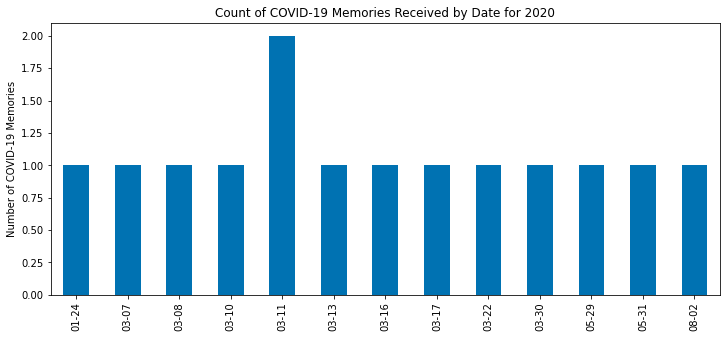

In [20]:
# plot counts of memories by date
fig = plt.figure(figsize=(12,5))
df_survey_raw['CDmm-dd'].value_counts().sort_index().plot(kind='bar')
plt.ylabel("Number of COVID-19 Memories")
plt.title("Count of COVID-19 Memories Received by Date for 2020")
plt.savefig('/Users/diedrebrown/Desktop/GitHubRepos/inthetimeofcovid/images/2020-memoriesbydate.png', dpi=300)
plt.show()

3/11/2020 was the only date to receive two entries.

2021-04-19 14:08:20,758 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-04-19 14:08:20,761 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2021-04-19 14:08:20,765 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


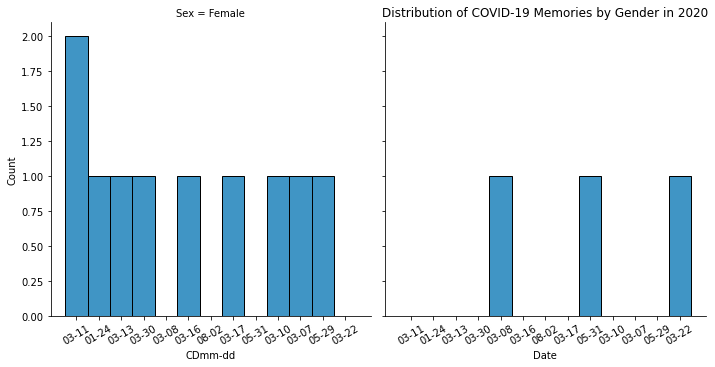

In [35]:
# plot counts of memories by date by gender
g = sns.displot(data=df_survey_raw, x="CDmm-dd", col="Sex", kde=False)
g.set_xticklabels(rotation=30)
plt.xlabel("Date")
plt.title("Distribution of COVID-19 Memories by Gender in 2020")
plt.show()

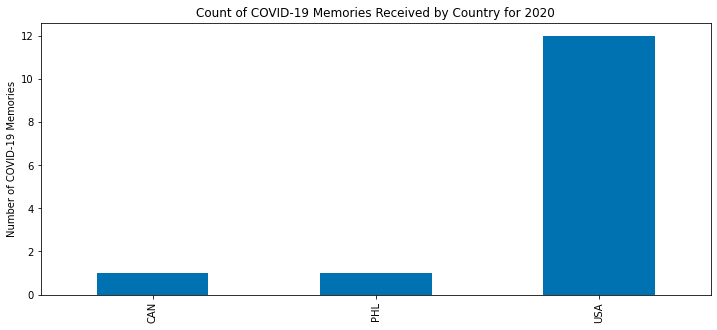

In [21]:
# plot counts of memories by country
fig = plt.figure(figsize=(12,5))
df_survey_raw['Ccountry-iso_alpha'].value_counts().sort_index().plot(kind='bar')
plt.ylabel("Number of COVID-19 Memories")
plt.title("Count of COVID-19 Memories Received by Country for 2020")
plt.savefig('/Users/diedrebrown/Desktop/GitHubRepos/inthetimeofcovid/images/2020-memoriesbycountry.png', dpi=300)
plt.show()

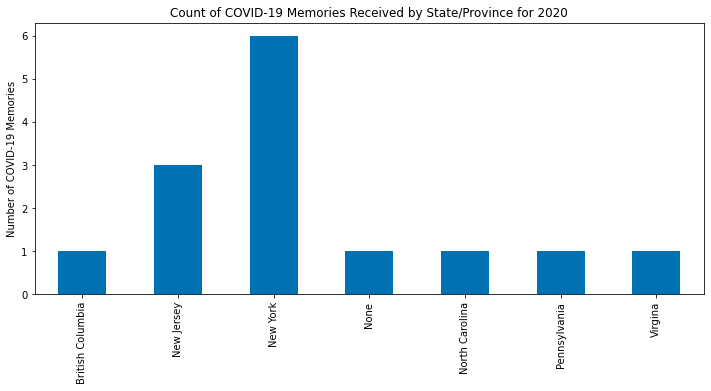

In [22]:
# plot counts of memories by state
fig = plt.figure(figsize=(12,5))
df_survey_raw['CState'].value_counts().sort_index().plot(kind='bar')
plt.ylabel("Number of COVID-19 Memories")
plt.title("Count of COVID-19 Memories Received by State/Province for 2020")
plt.savefig('/Users/diedrebrown/Desktop/GitHubRepos/inthetimeofcovid/images/2020-memoriesbystate.png', dpi=300)
plt.show()

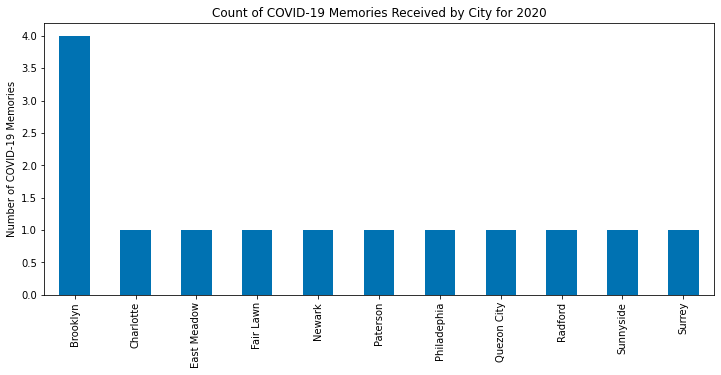

In [23]:
# plot counts of memories by state
fig = plt.figure(figsize=(12,5))
df_survey_raw['CCity'].value_counts().sort_index().plot(kind='bar')
plt.ylabel("Number of COVID-19 Memories")
plt.title("Count of COVID-19 Memories Received by City for 2020")
plt.savefig('/Users/diedrebrown/Desktop/GitHubRepos/inthetimeofcovid/images/2020-memoriesbycity.png', dpi=300)
plt.show()

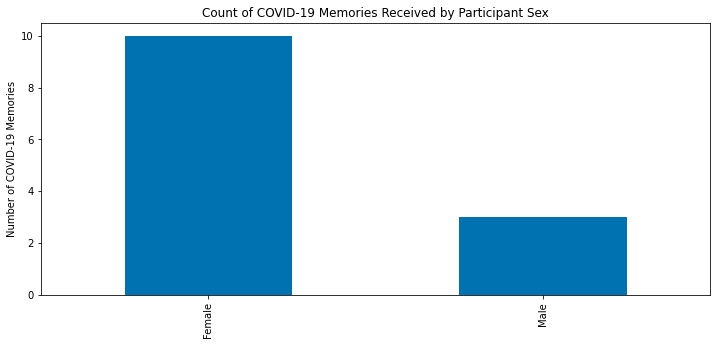

In [24]:
# plot counts of memories by participant sex
fig = plt.figure(figsize=(12,5))
df_survey_raw['Sex'].value_counts().sort_index().plot(kind='bar')
plt.ylabel("Number of COVID-19 Memories")
plt.title("Count of COVID-19 Memories Received by Participant Sex")
plt.savefig('/Users/diedrebrown/Desktop/GitHubRepos/inthetimeofcovid/images/2020-memoriesbysex.png', dpi=300)
plt.show()

In [59]:
# plotly version
persex = df_survey_raw['Sex'].value_counts().sort_index()
fig = px.pie(persex, values='Sex',names=['Female','Male'], color=['Female','Male'],
        color_discrete_map={'Female':'#FFD297','Male':'#26445E'},
        title="Count of COVID-19 Memories Received by Participant Sex")
fig.show()

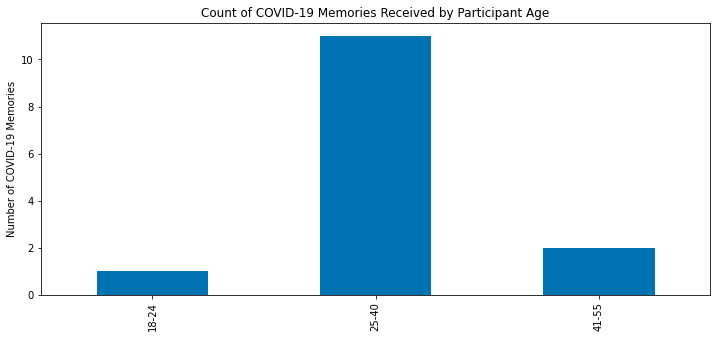

In [25]:
# plot counts of memories by participant age
fig = plt.figure(figsize=(12,5))
df_survey_raw['Age'].value_counts().sort_index().plot(kind='bar')
plt.ylabel("Number of COVID-19 Memories")
plt.title("Count of COVID-19 Memories Received by Participant Age")
plt.savefig('/Users/diedrebrown/Desktop/GitHubRepos/inthetimeofcovid/images/2020-memoriesbyage.png', dpi=300)
plt.show()

In [26]:
# let's see the length of each review and then plot this
df_survey_raw['length']=df_survey_raw['Mem'].apply(len)
df_survey_raw.head()

,P,Age,Sex,CDate,CCity,CState,Ccountry-iso_alpha,Mem,3Wrds,ColorB,ColorHex,ColorRes,CDyear,CDmm-dd,length
0,A,25-40,Female,2020-03-11,Surrey,British Columbia,CAN,I recall having a team meeting at work with lo...,"Fun, overwhelming, tiring",I have no color deficiency.,NONE,NONE,2020,03-11,267
1,B,25-40,Female,2020-01-24,Brooklyn,New York,USA,A lot of things came to my mind. It was hard t...,"Chinese, friendly, funny",I have no color deficiency.,#CC0000,Red is the official color of Chinese New Year:),2020,01-24,1555
2,C,41-55,Female,2020-03-13,Brooklyn,New York,USA,It was the day that I learned that public scho...,"disbelief, confusion, concern",I have no color deficiency.,#660000,"Red reminds me of school, and concern",2020,03-13,89
3,D,25-40,Female,2020-03-30,Radford,Virgina,USA,My Grandmother passed away and we couldn’t gri...,"Angry, Sunken, bitter",I have no color deficiency.,#330066,It feels like a somber color,2020,03-30,466
4,E,25-40,Male,2020-03-08,Newark,New Jersey,USA,I hope this doesn’t feel like too ‘silly’ of a...,"Exhilarating, overindulgent, inspiring",I have no color deficiency.,#CC0000,"The concert design largely used this color, so...",2020,03-08,1131


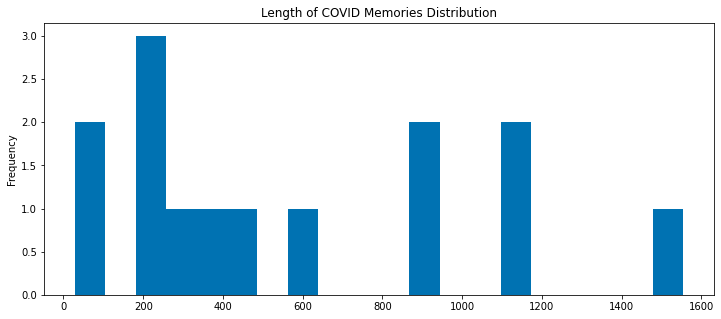

In [27]:
# plot counts of memories by length
fig = plt.figure(figsize=(12,5))
df_survey_raw['length'].plot.hist(bins=20)
plt.ylabel("Frequency")
plt.title("Length of COVID Memories Distribution")
plt.savefig('/Users/diedrebrown/Desktop/GitHubRepos/inthetimeofcovid/images/2020-memoriesbylength.png', dpi=300)
plt.show()

In [28]:
df_survey_raw['length'].describe()

count      14.000000
mean      578.142857
std       463.502860
min        28.000000
25%       220.000000
50%       431.500000
75%       880.250000
max      1555.000000
Name: length, dtype: float64

The longest memory was 1555 characters in length, but the average memory was 578 characters long.

In [64]:
# let's look at the shortest and longest memories
# shortest
df_survey_raw[df_survey_raw['length']==28]

,P,Age,Sex,CDate,CCity,CState,Ccountry-iso_alpha,Mem,3Wrds,ColorB,ColorHex,ColorRes,CDyear,CDmm-dd,length
9,J,41-55,Female,2020-03-10,Quezon City,None,PHL,My mother in law passed away,"scared, panicked, confused",I have no color deficiency.,#FF6666,It is like a fading red color. There is still ...,2020,03-10,28


In [65]:
df_survey_raw[df_survey_raw['length']==28]['Mem'].iloc[0]

'My mother in law passed away'

In [66]:
df_survey_raw[df_survey_raw['length']==1555]

,P,Age,Sex,CDate,CCity,CState,Ccountry-iso_alpha,Mem,3Wrds,ColorB,ColorHex,ColorRes,CDyear,CDmm-dd,length
1,B,25-40,Female,2020-01-24,Brooklyn,New York,USA,A lot of things came to my mind. It was hard t...,"Chinese, friendly, funny",I have no color deficiency.,#CC0000,Red is the official color of Chinese New Year:),2020,01-24,1555


In [67]:
df_survey_raw[df_survey_raw['length']==1555]['Mem'].iloc[0]

"A lot of things came to my mind. It was hard to choose something specific, nothing special happened during the time of pandemic with me. It’s more about adaptation to the new “isolated” lifestyle. And all the simple things such as going outside with a friend, 1-day trip somewhere to the upstate, meeting new person… all these getting more special than it was before. \nOne thing I wanted to describe in 2020 is the Chinese New Year. It was the night between Jan 24 and Jan 25. Like a month before Pratt was closed and we started to take classes/work from home. Some people already started wearing masks. Soo it was a party somewhere in Ridgewood organized by one of the students at Pratt. I wasn’t sure I want to go because I knew nothing about Chinese traditions and had no idea what we all are going to do there. They also asked to wear everything red (“good-luck” tradition) and I had no red clothes at all. This day I got a text message from Martha. She asked if we can go together. She also ha

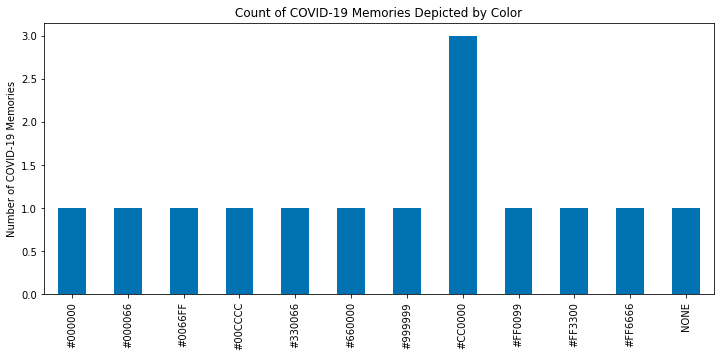

In [68]:
# plot counts of memories by color
fig = plt.figure(figsize=(12,5))
df_survey_raw['ColorHex'].value_counts().sort_index().plot(kind='bar')
plt.ylabel("Number of COVID-19 Memories")
plt.title("Count of COVID-19 Memories Depicted by Color")
plt.savefig('/Users/diedrebrown/Desktop/GitHubRepos/inthetimeofcovid/images/2020-memoriesbycolor.png', dpi=300)
plt.show()

In [75]:
df_survey_raw['ColorHex'].describe()

count          14
unique         12
top       #CC0000
freq            3
Name: ColorHex, dtype: object

## Sentiment Analysis

In [39]:
# load df
df_covidtext = df_survey_raw
df_covidtext

,P,Age,Sex,CDate,CCity,CState,Ccountry-iso_alpha,Mem,3Wrds,ColorB,ColorHex,ColorRes,CDyear,CDmm-dd,length
0,A,25-40,Female,2020-03-11,Surrey,British Columbia,CAN,I recall having a team meeting at work with lo...,"Fun, overwhelming, tiring",I have no color deficiency.,NONE,NONE,2020,03-11,267
1,B,25-40,Female,2020-01-24,Brooklyn,New York,USA,A lot of things came to my mind. It was hard t...,"Chinese, friendly, funny",I have no color deficiency.,#CC0000,Red is the official color of Chinese New Year:),2020,01-24,1555
2,C,41-55,Female,2020-03-13,Brooklyn,New York,USA,It was the day that I learned that public scho...,"disbelief, confusion, concern",I have no color deficiency.,#660000,"Red reminds me of school, and concern",2020,03-13,89
3,D,25-40,Female,2020-03-30,Radford,Virgina,USA,My Grandmother passed away and we couldn’t gri...,"Angry, Sunken, bitter",I have no color deficiency.,#330066,It feels like a somber color,2020,03-30,466
4,E,25-40,Male,2020-03-08,Newark,New Jersey,USA,I hope this doesn’t feel like too ‘silly’ of a...,"Exhilarating, overindulgent, inspiring",I have no color deficiency.,#CC0000,"The concert design largely used this color, so...",2020,03-08,1131
5,F,25-40,Female,2020-03-16,Charlotte,North Carolina,USA,It was the day I broke down and almost ruined ...,"stressful, upset, hysterical",I have no color deficiency.,#FF3300,"There were high tensions, but no rage, which I...",2020,03-16,1110
6,G,25-40,NaN,2020-08-02,Sunnyside,New York,USA,Based on your parameters this was part of the ...,"Relief, pain, anxious",I have no color deficiency.,#FF0099,"Bold color but pleasing, slightly unsettling",2020,08-02,397
7,H,18-24,Female,2020-03-17,East Meadow,New York,USA,This is the date that everything closed down. ...,"Scared, surreal, worried",I have no color deficiency.,#000066,"Blue to me is a nervous, cold, anxious color. ...",2020,03-17,256
8,I,25-40,Male,2020-05-31,Philadephia,Pennsylvania,USA,Attended my first public gathering in protest....,"enlightening, freeing, powerful",I have no color deficiency.,#CC0000,I think it was mostly due to the colors I saw ...,2020,05-31,632
9,J,41-55,Female,2020-03-10,Quezon City,None,PHL,My mother in law passed away,"scared, panicked, confused",I have no color deficiency.,#FF6666,It is like a fading red color. There is still ...,2020,03-10,28


In [40]:
# let's pull just the Mem and 3Wrds columns from the dfcovidtext
df_memcorpus = df_covidtext[['Mem','3Wrds','ColorHex',	'ColorRes']]
df_memcorpus

,Mem,3Wrds,ColorHex,ColorRes
0,I recall having a team meeting at work with lo...,"Fun, overwhelming, tiring",NONE,NONE
1,A lot of things came to my mind. It was hard t...,"Chinese, friendly, funny",#CC0000,Red is the official color of Chinese New Year:)
2,It was the day that I learned that public scho...,"disbelief, confusion, concern",#660000,"Red reminds me of school, and concern"
3,My Grandmother passed away and we couldn’t gri...,"Angry, Sunken, bitter",#330066,It feels like a somber color
4,I hope this doesn’t feel like too ‘silly’ of a...,"Exhilarating, overindulgent, inspiring",#CC0000,"The concert design largely used this color, so..."
5,It was the day I broke down and almost ruined ...,"stressful, upset, hysterical",#FF3300,"There were high tensions, but no rage, which I..."
6,Based on your parameters this was part of the ...,"Relief, pain, anxious",#FF0099,"Bold color but pleasing, slightly unsettling"
7,This is the date that everything closed down. ...,"Scared, surreal, worried",#000066,"Blue to me is a nervous, cold, anxious color. ..."
8,Attended my first public gathering in protest....,"enlightening, freeing, powerful",#CC0000,I think it was mostly due to the colors I saw ...
9,My mother in law passed away,"scared, panicked, confused",#FF6666,It is like a fading red color. There is still ...


### VADER (Valence Aware Dictionary for sEntiment Reasoning)
Vader is a model used for text sentiment analysis that is sensitive to both polarity (pos/neg) and instensity (strenght) of emotion.

In [41]:
# Create an object/instance
sent = SentimentIntensityAnalyzer()

In [42]:
# Sentiment of COVID Memory
score_com = []
score_pos = []
score_neg = []
for i in range(0,df_memcorpus.shape[0] ):
    memscore = sent.polarity_scores(df_memcorpus['Mem'].iloc[i])
    score1 = memscore['compound']
    score_com.append(score1)
    # extract the positive sentiment
    score2 = memscore['pos']
    score_pos.append(score2)
    # extract the negative sentiment
    score2 = memscore['neg']
    score_neg.append(score2)

In [43]:
df_memcorpus['MemCScore'] = score_com
df_memcorpus['MemPScore'] = score_pos
df_memcorpus['MemNScore'] = score_neg

In [44]:
df_memcorpus

,Mem,3Wrds,ColorHex,ColorRes,MemCScore,MemPScore,MemNScore
0,I recall having a team meeting at work with lo...,"Fun, overwhelming, tiring",NONE,NONE,0.5562,0.072,0.000
1,A lot of things came to my mind. It was hard t...,"Chinese, friendly, funny",#CC0000,Red is the official color of Chinese New Year:),0.8772,0.077,0.049
2,It was the day that I learned that public scho...,"disbelief, confusion, concern",#660000,"Red reminds me of school, and concern",0.0000,0.000,0.000
3,My Grandmother passed away and we couldn’t gri...,"Angry, Sunken, bitter",#330066,It feels like a somber color,-0.8834,0.066,0.176
4,I hope this doesn’t feel like too ‘silly’ of a...,"Exhilarating, overindulgent, inspiring",#CC0000,"The concert design largely used this color, so...",0.9354,0.107,0.051
5,It was the day I broke down and almost ruined ...,"stressful, upset, hysterical",#FF3300,"There were high tensions, but no rage, which I...",-0.8951,0.080,0.161
6,Based on your parameters this was part of the ...,"Relief, pain, anxious",#FF0099,"Bold color but pleasing, slightly unsettling",-0.2714,0.000,0.027
7,This is the date that everything closed down. ...,"Scared, surreal, worried",#000066,"Blue to me is a nervous, cold, anxious color. ...",-0.6453,0.000,0.109
8,Attended my first public gathering in protest....,"enlightening, freeing, powerful",#CC0000,I think it was mostly due to the colors I saw ...,0.9274,0.174,0.053
9,My mother in law passed away,"scared, panicked, confused",#FF6666,It is like a fading red color. There is still ...,0.0000,0.000,0.000


In [45]:
# Sentiment of 3Wrds
score_com = []
score_pos = []
score_neg = []
for i in range(0,df_memcorpus.shape[0] ):
    memscore = sent.polarity_scores(df_memcorpus['3Wrds'].iloc[i])
    score1 = memscore['compound']
    score_com.append(score1)
    # extract the positive sentiment
    score2 = memscore['pos']
    score_pos.append(score2)
    # extract the negative sentiment
    score2 = memscore['neg']
    score_neg.append(score2)

In [46]:
df_memcorpus['3WCScore'] = score_com
df_memcorpus['3WPScore'] = score_pos
df_memcorpus['3WNScore'] = score_neg

In [47]:
df_memcorpus

,Mem,3Wrds,ColorHex,ColorRes,MemCScore,MemPScore,MemNScore,3WCScore,3WPScore,3WNScore
0,I recall having a team meeting at work with lo...,"Fun, overwhelming, tiring",NONE,NONE,0.5562,0.072,0.000,0.5106,0.623,0.000
1,A lot of things came to my mind. It was hard t...,"Chinese, friendly, funny",#CC0000,Red is the official color of Chinese New Year:),0.8772,0.077,0.049,0.7269,0.859,0.000
2,It was the day that I learned that public scho...,"disbelief, confusion, concern",#660000,"Red reminds me of school, and concern",0.0000,0.000,0.000,-0.2960,0.000,0.524
3,My Grandmother passed away and we couldn’t gri...,"Angry, Sunken, bitter",#330066,It feels like a somber color,-0.8834,0.066,0.176,-0.7269,0.000,0.859
4,I hope this doesn’t feel like too ‘silly’ of a...,"Exhilarating, overindulgent, inspiring",#CC0000,"The concert design largely used this color, so...",0.9354,0.107,0.051,0.6705,0.846,0.000
5,It was the day I broke down and almost ruined ...,"stressful, upset, hysterical",#FF3300,"There were high tensions, but no rage, which I...",-0.8951,0.080,0.161,-0.7184,0.000,1.000
6,Based on your parameters this was part of the ...,"Relief, pain, anxious",#FF0099,"Bold color but pleasing, slightly unsettling",-0.2714,0.000,0.027,-0.2960,0.369,0.631
7,This is the date that everything closed down. ...,"Scared, surreal, worried",#000066,"Blue to me is a nervous, cold, anxious color. ...",-0.6453,0.000,0.109,-0.6249,0.000,0.836
8,Attended my first public gathering in protest....,"enlightening, freeing, powerful",#CC0000,I think it was mostly due to the colors I saw ...,0.9274,0.174,0.053,0.8481,1.000,0.000
9,My mother in law passed away,"scared, panicked, confused",#FF6666,It is like a fading red color. There is still ...,0.0000,0.000,0.000,-0.8020,0.000,1.000


In [48]:
# Sentiment of Color
score_com = []
score_pos = []
score_neg = []
for i in range(0,df_memcorpus.shape[0] ):
    memscore = sent.polarity_scores(df_memcorpus['ColorRes'].iloc[i])
    score1 = memscore['compound']
    score_com.append(score1)
    # extract the positive sentiment
    score2 = memscore['pos']
    score_pos.append(score2)
    # extract the negative sentiment
    score2 = memscore['neg']
    score_neg.append(score2)

In [49]:
df_memcorpus['ColCScore'] = score_com
df_memcorpus['ColPScore'] = score_pos
df_memcorpus['ColNScore'] = score_neg
df_memcorpus

,Mem,3Wrds,ColorHex,ColorRes,MemCScore,MemPScore,MemNScore,3WCScore,3WPScore,3WNScore,ColCScore,ColPScore,ColNScore
0,I recall having a team meeting at work with lo...,"Fun, overwhelming, tiring",NONE,NONE,0.5562,0.072,0.000,0.5106,0.623,0.000,0.0000,0.000,0.000
1,A lot of things came to my mind. It was hard t...,"Chinese, friendly, funny",#CC0000,Red is the official color of Chinese New Year:),0.8772,0.077,0.049,0.7269,0.859,0.000,0.0000,0.000,0.000
2,It was the day that I learned that public scho...,"disbelief, confusion, concern",#660000,"Red reminds me of school, and concern",0.0000,0.000,0.000,-0.2960,0.000,0.524,0.0000,0.000,0.000
3,My Grandmother passed away and we couldn’t gri...,"Angry, Sunken, bitter",#330066,It feels like a somber color,-0.8834,0.066,0.176,-0.7269,0.000,0.859,-0.0772,0.301,0.337
4,I hope this doesn’t feel like too ‘silly’ of a...,"Exhilarating, overindulgent, inspiring",#CC0000,"The concert design largely used this color, so...",0.9354,0.107,0.051,0.6705,0.846,0.000,0.0000,0.000,0.000
5,It was the day I broke down and almost ruined ...,"stressful, upset, hysterical",#FF3300,"There were high tensions, but no rage, which I...",-0.8951,0.080,0.161,-0.7184,0.000,1.000,-0.9618,0.087,0.507
6,Based on your parameters this was part of the ...,"Relief, pain, anxious",#FF0099,"Bold color but pleasing, slightly unsettling",-0.2714,0.000,0.027,-0.2960,0.369,0.631,0.7506,0.615,0.000
7,This is the date that everything closed down. ...,"Scared, surreal, worried",#000066,"Blue to me is a nervous, cold, anxious color. ...",-0.6453,0.000,0.109,-0.6249,0.000,0.836,0.1761,0.151,0.160
8,Attended my first public gathering in protest....,"enlightening, freeing, powerful",#CC0000,I think it was mostly due to the colors I saw ...,0.9274,0.174,0.053,0.8481,1.000,0.000,0.0000,0.000,0.000
9,My mother in law passed away,"scared, panicked, confused",#FF6666,It is like a fading red color. There is still ...,0.0000,0.000,0.000,-0.8020,0.000,1.000,-0.8945,0.142,0.376


In [50]:
# rearrange columns
cols = list(df_memcorpus.columns)
cols

['Mem',
 '3Wrds',
 'ColorHex',
 'ColorRes',
 'MemCScore',
 'MemPScore',
 'MemNScore',
 '3WCScore',
 '3WPScore',
 '3WNScore',
 'ColCScore',
 'ColPScore',
 'ColNScore']

In [51]:
cols[1], cols[2], cols[3],cols[4], cols[5], cols[6] = cols[4], cols[5], cols[6], cols[1], cols[2], cols[3]
cols

['Mem',
 'MemCScore',
 'MemPScore',
 'MemNScore',
 '3Wrds',
 'ColorHex',
 'ColorRes',
 '3WCScore',
 '3WPScore',
 '3WNScore',
 'ColCScore',
 'ColPScore',
 'ColNScore']

In [52]:
cols[5],cols[6], cols[7], cols[8], cols[9] = cols[7], cols[8], cols[9],cols[5], cols[6]
cols

['Mem',
 'MemCScore',
 'MemPScore',
 'MemNScore',
 '3Wrds',
 '3WCScore',
 '3WPScore',
 '3WNScore',
 'ColorHex',
 'ColorRes',
 'ColCScore',
 'ColPScore',
 'ColNScore']

In [53]:
# reattach list
df_memcorpus = df_memcorpus[cols]
df_memcorpus

,Mem,MemCScore,MemPScore,MemNScore,3Wrds,3WCScore,3WPScore,3WNScore,ColorHex,ColorRes,ColCScore,ColPScore,ColNScore
0,I recall having a team meeting at work with lo...,0.5562,0.072,0.000,"Fun, overwhelming, tiring",0.5106,0.623,0.000,NONE,NONE,0.0000,0.000,0.000
1,A lot of things came to my mind. It was hard t...,0.8772,0.077,0.049,"Chinese, friendly, funny",0.7269,0.859,0.000,#CC0000,Red is the official color of Chinese New Year:),0.0000,0.000,0.000
2,It was the day that I learned that public scho...,0.0000,0.000,0.000,"disbelief, confusion, concern",-0.2960,0.000,0.524,#660000,"Red reminds me of school, and concern",0.0000,0.000,0.000
3,My Grandmother passed away and we couldn’t gri...,-0.8834,0.066,0.176,"Angry, Sunken, bitter",-0.7269,0.000,0.859,#330066,It feels like a somber color,-0.0772,0.301,0.337
4,I hope this doesn’t feel like too ‘silly’ of a...,0.9354,0.107,0.051,"Exhilarating, overindulgent, inspiring",0.6705,0.846,0.000,#CC0000,"The concert design largely used this color, so...",0.0000,0.000,0.000
5,It was the day I broke down and almost ruined ...,-0.8951,0.080,0.161,"stressful, upset, hysterical",-0.7184,0.000,1.000,#FF3300,"There were high tensions, but no rage, which I...",-0.9618,0.087,0.507
6,Based on your parameters this was part of the ...,-0.2714,0.000,0.027,"Relief, pain, anxious",-0.2960,0.369,0.631,#FF0099,"Bold color but pleasing, slightly unsettling",0.7506,0.615,0.000
7,This is the date that everything closed down. ...,-0.6453,0.000,0.109,"Scared, surreal, worried",-0.6249,0.000,0.836,#000066,"Blue to me is a nervous, cold, anxious color. ...",0.1761,0.151,0.160
8,Attended my first public gathering in protest....,0.9274,0.174,0.053,"enlightening, freeing, powerful",0.8481,1.000,0.000,#CC0000,I think it was mostly due to the colors I saw ...,0.0000,0.000,0.000
9,My mother in law passed away,0.0000,0.000,0.000,"scared, panicked, confused",-0.8020,0.000,1.000,#FF6666,It is like a fading red color. There is still ...,-0.8945,0.142,0.376


In [55]:
# average Memory and 3WRD scores
df_memcorpus['Mem3CScore'] = ((df_memcorpus['MemCScore']+df_memcorpus['3WCScore'])/2)
df_memcorpus

,Mem,MemCScore,MemPScore,MemNScore,3Wrds,3WCScore,3WPScore,3WNScore,ColorHex,ColorRes,ColCScore,ColPScore,ColNScore,Mem3CScore
0,I recall having a team meeting at work with lo...,0.5562,0.072,0.000,"Fun, overwhelming, tiring",0.5106,0.623,0.000,NONE,NONE,0.0000,0.000,0.000,0.53340
1,A lot of things came to my mind. It was hard t...,0.8772,0.077,0.049,"Chinese, friendly, funny",0.7269,0.859,0.000,#CC0000,Red is the official color of Chinese New Year:),0.0000,0.000,0.000,0.80205
2,It was the day that I learned that public scho...,0.0000,0.000,0.000,"disbelief, confusion, concern",-0.2960,0.000,0.524,#660000,"Red reminds me of school, and concern",0.0000,0.000,0.000,-0.14800
3,My Grandmother passed away and we couldn’t gri...,-0.8834,0.066,0.176,"Angry, Sunken, bitter",-0.7269,0.000,0.859,#330066,It feels like a somber color,-0.0772,0.301,0.337,-0.80515
4,I hope this doesn’t feel like too ‘silly’ of a...,0.9354,0.107,0.051,"Exhilarating, overindulgent, inspiring",0.6705,0.846,0.000,#CC0000,"The concert design largely used this color, so...",0.0000,0.000,0.000,0.80295
5,It was the day I broke down and almost ruined ...,-0.8951,0.080,0.161,"stressful, upset, hysterical",-0.7184,0.000,1.000,#FF3300,"There were high tensions, but no rage, which I...",-0.9618,0.087,0.507,-0.80675
6,Based on your parameters this was part of the ...,-0.2714,0.000,0.027,"Relief, pain, anxious",-0.2960,0.369,0.631,#FF0099,"Bold color but pleasing, slightly unsettling",0.7506,0.615,0.000,-0.28370
7,This is the date that everything closed down. ...,-0.6453,0.000,0.109,"Scared, surreal, worried",-0.6249,0.000,0.836,#000066,"Blue to me is a nervous, cold, anxious color. ...",0.1761,0.151,0.160,-0.63510
8,Attended my first public gathering in protest....,0.9274,0.174,0.053,"enlightening, freeing, powerful",0.8481,1.000,0.000,#CC0000,I think it was mostly due to the colors I saw ...,0.0000,0.000,0.000,0.88775
9,My mother in law passed away,0.0000,0.000,0.000,"scared, panicked, confused",-0.8020,0.000,1.000,#FF6666,It is like a fading red color. There is still ...,-0.8945,0.142,0.376,-0.40100


In [ ]:
df_memcorpus
df_covidtext

In [57]:
df_memall = (df_covidtext.merge(df_memcorpus))
df_memall

,P,Age,Sex,CDate,CCity,CState,Ccountry-iso_alpha,Mem,3Wrds,ColorB,...,MemCScore,MemPScore,MemNScore,3WCScore,3WPScore,3WNScore,ColCScore,ColPScore,ColNScore,Mem3CScore
0,A,25-40,Female,2020-03-11,Surrey,British Columbia,CAN,I recall having a team meeting at work with lo...,"Fun, overwhelming, tiring",I have no color deficiency.,...,0.5562,0.072,0.000,0.5106,0.623,0.000,0.0000,0.000,0.000,0.53340
1,B,25-40,Female,2020-01-24,Brooklyn,New York,USA,A lot of things came to my mind. It was hard t...,"Chinese, friendly, funny",I have no color deficiency.,...,0.8772,0.077,0.049,0.7269,0.859,0.000,0.0000,0.000,0.000,0.80205
2,C,41-55,Female,2020-03-13,Brooklyn,New York,USA,It was the day that I learned that public scho...,"disbelief, confusion, concern",I have no color deficiency.,...,0.0000,0.000,0.000,-0.2960,0.000,0.524,0.0000,0.000,0.000,-0.14800
3,D,25-40,Female,2020-03-30,Radford,Virgina,USA,My Grandmother passed away and we couldn’t gri...,"Angry, Sunken, bitter",I have no color deficiency.,...,-0.8834,0.066,0.176,-0.7269,0.000,0.859,-0.0772,0.301,0.337,-0.80515
4,E,25-40,Male,2020-03-08,Newark,New Jersey,USA,I hope this doesn’t feel like too ‘silly’ of a...,"Exhilarating, overindulgent, inspiring",I have no color deficiency.,...,0.9354,0.107,0.051,0.6705,0.846,0.000,0.0000,0.000,0.000,0.80295
5,F,25-40,Female,2020-03-16,Charlotte,North Carolina,USA,It was the day I broke down and almost ruined ...,"stressful, upset, hysterical",I have no color deficiency.,...,-0.8951,0.080,0.161,-0.7184,0.000,1.000,-0.9618,0.087,0.507,-0.80675
6,G,25-40,NaN,2020-08-02,Sunnyside,New York,USA,Based on your parameters this was part of the ...,"Relief, pain, anxious",I have no color deficiency.,...,-0.2714,0.000,0.027,-0.2960,0.369,0.631,0.7506,0.615,0.000,-0.28370
7,H,18-24,Female,2020-03-17,East Meadow,New York,USA,This is the date that everything closed down. ...,"Scared, surreal, worried",I have no color deficiency.,...,-0.6453,0.000,0.109,-0.6249,0.000,0.836,0.1761,0.151,0.160,-0.63510
8,I,25-40,Male,2020-05-31,Philadephia,Pennsylvania,USA,Attended my first public gathering in protest....,"enlightening, freeing, powerful",I have no color deficiency.,...,0.9274,0.174,0.053,0.8481,1.000,0.000,0.0000,0.000,0.000,0.88775
9,J,41-55,Female,2020-03-10,Quezon City,None,PHL,My mother in law passed away,"scared, panicked, confused",I have no color deficiency.,...,0.0000,0.000,0.000,-0.8020,0.000,1.000,-0.8945,0.142,0.376,-0.40100


In [58]:
# Save memall to pickle file
df_memall.to_pickle("../data/df_memall.pickle")

In [59]:
# encode df_memall
le = LabelEncoder()
# go through the df and find the ones of object type
for col in df_memall:
    if df_memall[col].dtype == 'object':
        # use the labelencoder to transform to numeric
        df_memall[col] = le.fit_transform(df_memall[col])

# view modified df
df_memall.head()

,P,Age,Sex,CDate,CCity,CState,Ccountry-iso_alpha,Mem,3Wrds,ColorB,...,MemCScore,MemPScore,MemNScore,3WCScore,3WPScore,3WNScore,ColCScore,ColPScore,ColNScore,Mem3CScore
0,0,1,0,2020-03-11,10,0,0,4,5,0,...,0.5562,0.072,0.000,0.5106,0.623,0.000,0.0000,0.000,0.000,0.53340
1,1,1,0,2020-01-24,0,2,2,0,2,0,...,0.8772,0.077,0.049,0.7269,0.859,0.000,0.0000,0.000,0.000,0.80205
2,2,2,0,2020-03-13,0,2,2,6,9,0,...,0.0000,0.000,0.000,-0.2960,0.000,0.524,0.0000,0.000,0.000,-0.14800
3,3,1,0,2020-03-30,8,6,2,9,0,0,...,-0.8834,0.066,0.176,-0.7269,0.000,0.859,-0.0772,0.301,0.337,-0.80515
4,4,1,1,2020-03-08,4,1,2,3,4,0,...,0.9354,0.107,0.051,0.6705,0.846,0.000,0.0000,0.000,0.000,0.80295


<Figure size 2160x2160 with 0 Axes>

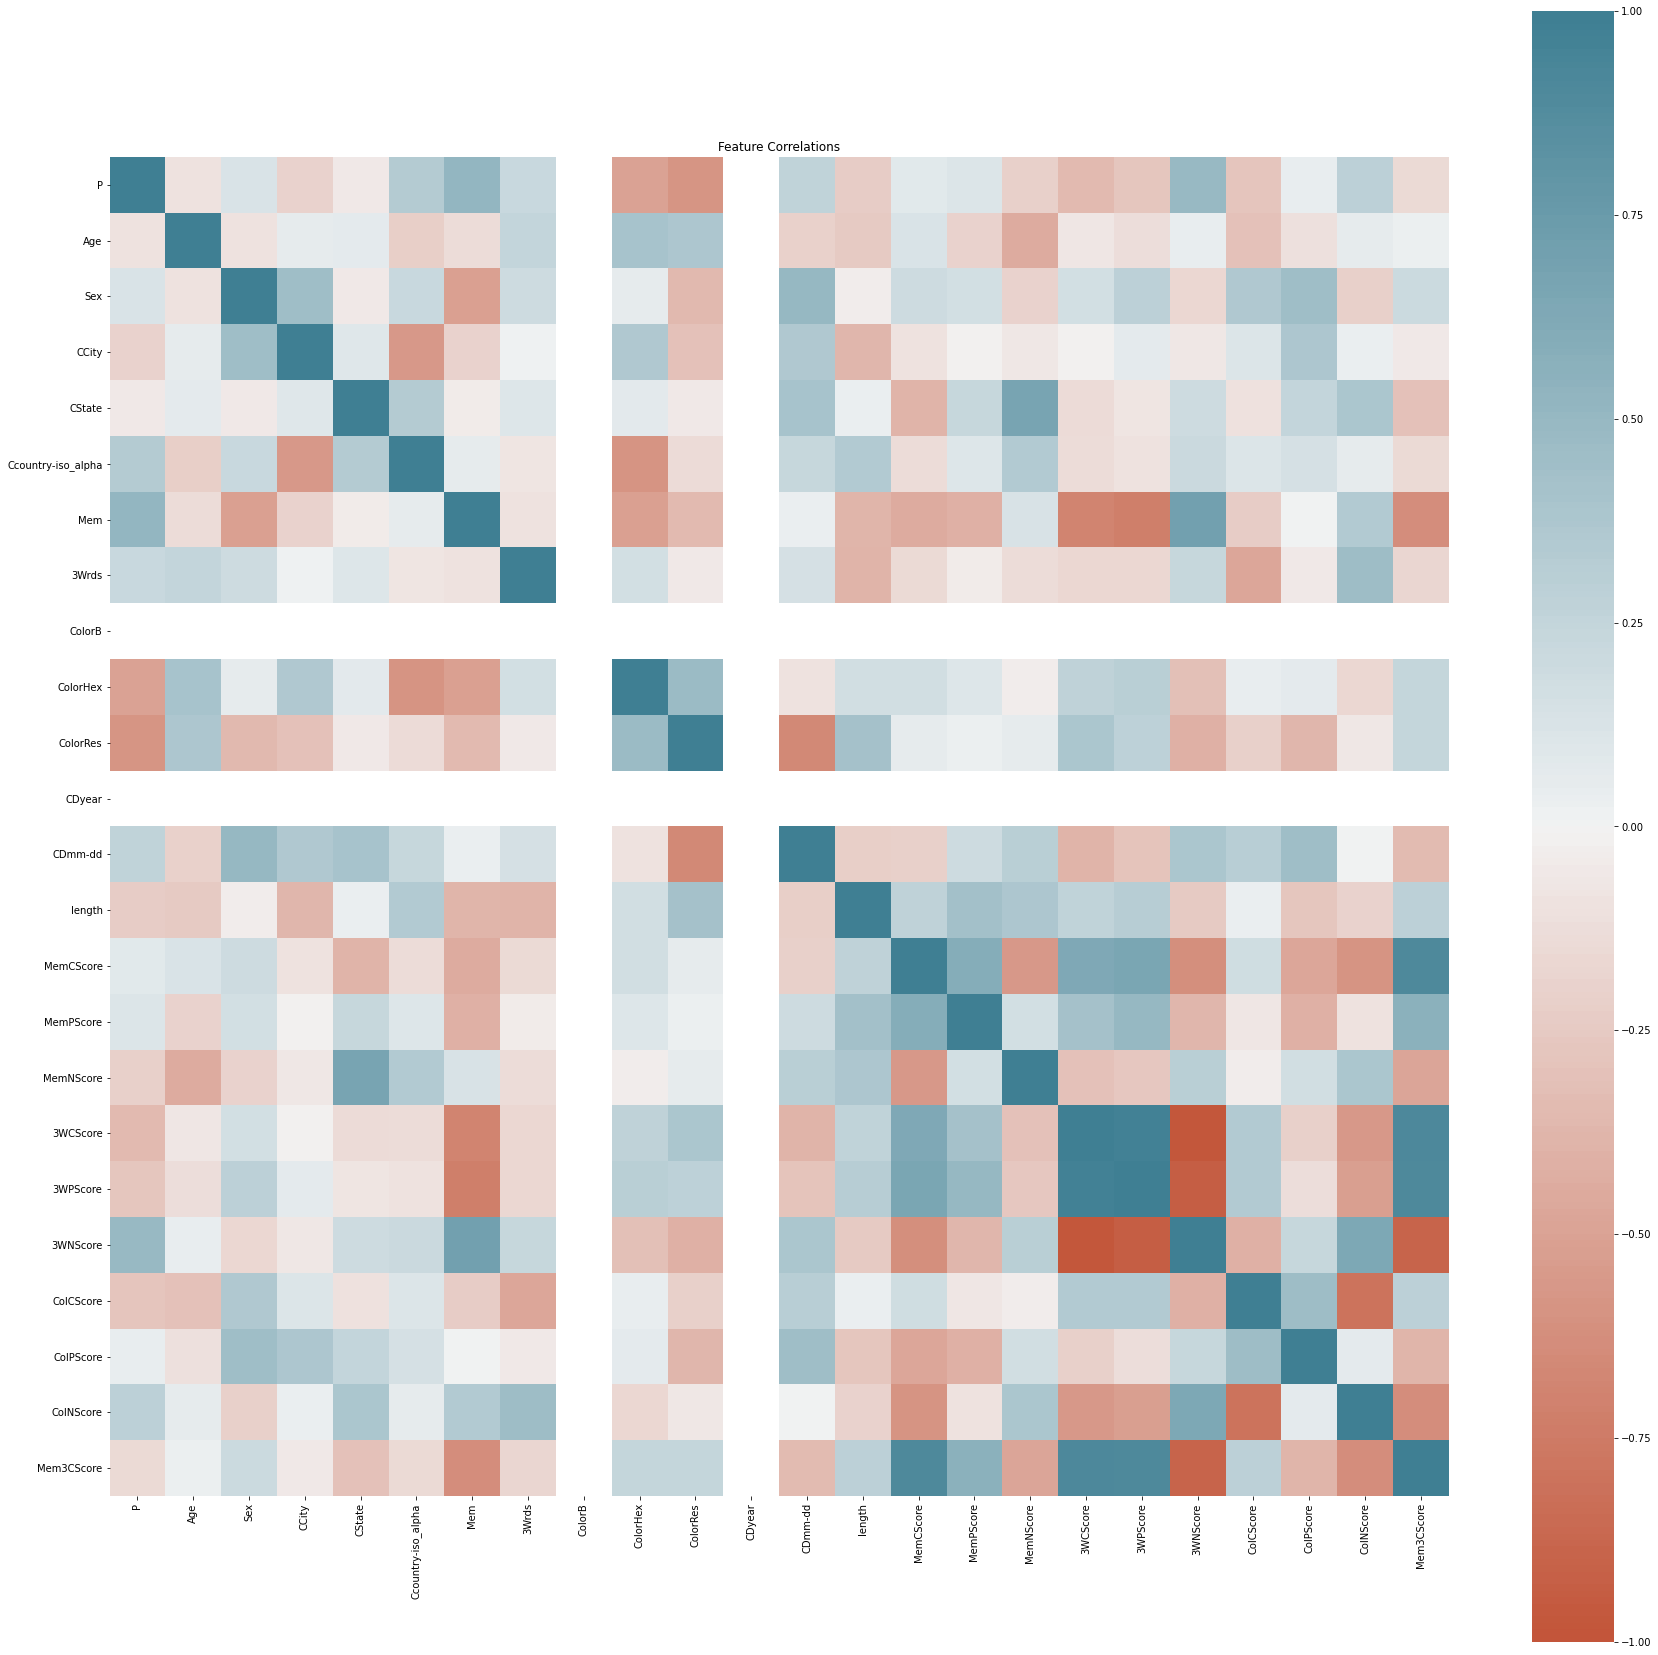

In [73]:
# Look for correlations
plt.figure(figsize=(30,30))
corr_matrix = plt.figure(figsize=(30,30))
corr_matrix = df_memall.corr()
ax = sns.heatmap(corr_matrix, vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=45,
#     horizontalalignment='right');
# ax.set_yticklabels(ax.get_xticklabels(),rotation=45,
#     horizontalalignment='right');

plt.title('Feature Correlations')
plt.savefig("../images/featurecorr.png")
plt.show()

In [64]:
print("Corr Sex - MemCScore:", df_memall['Sex'].corr(df_memall['MemCScore']))
print("Corr MemCScore - ColCScore:", df_memall['MemCScore'].corr(df_memall['ColCScore']))
print("Corr Sex - ColCScore:", df_memall['Sex'].corr(df_memall['ColCScore']))
print("Corr MemCScore - CDmm-dd:", df_memall['MemCScore'].corr(df_memall['CDmm-dd']))

Corr Sex - MemCScore: 0.19334174536486876
Corr MemCScore - ColCScore: 0.1811497996138786
Corr Sex - ColCScore: 0.3648902484675236
Corr MemCScore - CDmm-dd: -0.2117543246001483


In [65]:
print("Corr Sex - Mem3CScore:", df_memall['Sex'].corr(df_memall['Mem3CScore']))
# print("Corr MemCScore - ColCScore:", df_memall['MemCScore'].corr(df_memall['ColCScore']))
# print("Corr Sex - ColCScore:", df_memall['Sex'].corr(df_memall['ColCScore']))
# print("Corr MemCScore - CDmm-dd:", df_memall['MemCScore'].corr(df_memall['CDmm-dd']))

Corr Sex - Mem3CScore: 0.20097587285181875


In [ ]:
# CONTINUE WITH TOPIC MODELING